In [2]:
import torch
import torch.nn
#from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [1]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}%".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}%".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

### Download and load pretrained ResNet50 model

In [7]:
resnet50 = models.resnet50(pretrained=True) 
resnet50.eval();

In [3]:
# Downloading an image of a Panda
url = "https://cdn.britannica.com/80/150980-050-84B9202C/Giant-panda-cub-branch.jpg"  #tiger cat #i have uploaded 4 images to try- ex/ex2/ex3.jpg
response = requests.get(url)
img = Image.open(io.BytesIO(response.content))

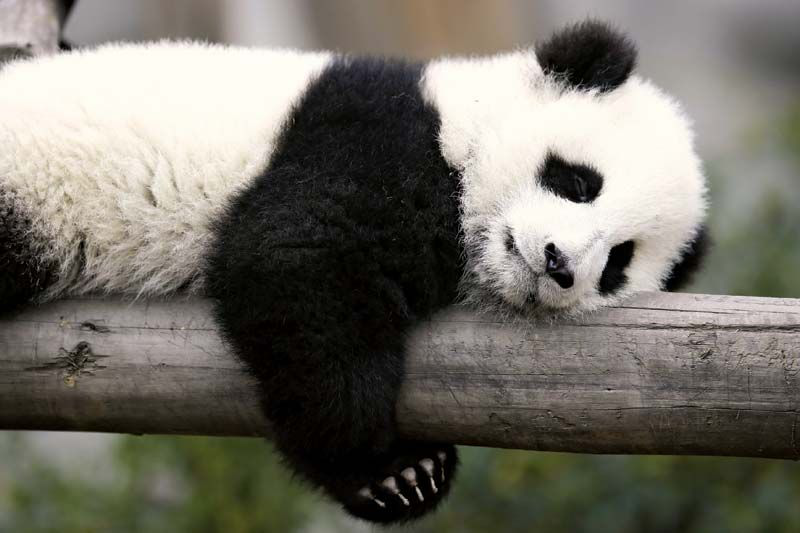

In [4]:
img

In [5]:
# ResNet50 pre-trained ImageNet Preprocessing
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [8]:
image_tensor = preprocess(img) # preprocess img
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W
img_variable = Variable(image_tensor, requires_grad=True) # convert tensor into a variable
output = resnet50.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   # get an index(class number) of a largest element

In [9]:
# Downloading labels json file that maps Indecies to String Labels
labels_link = "https://savan77.github.io/blog/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx]
#print(x_pred)

In [10]:
# Applying Softmax on the output logits to get values from 0 to 1
output_probs = F.softmax(output, dim=1)
# Finding the class with the highest Probability and multiply it by 100
x_pred_prob =  round(float((torch.max(output_probs.data, 1)[0][0] * 100)),2)


In [12]:
y_true = label_idx   # label index of the input image class
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([388])


### Fast Gradient Sign Method

In order to create an adversarial example, The Fast gradient sign method GOAL is to revert what the gradient descent has done during training by moving into the direction of moving away from optimal minima.
In some sense we are doing gradient ascent of the loss function with respect to the data to maximize the loss.


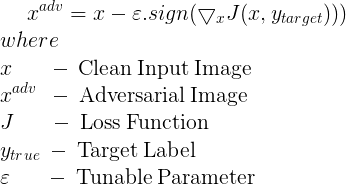


The formulation of The Fast gradient sign method where we calculate gradient values of J which is function of x and y the ground truth and multiply their sign by epsilon which is a small number that controls the size of the adversarial attack which needs to be chosen in order to be effective but not too obvious. So if we increase the value of epsilon the model will still make mistakes but the Adversarial Example will not be similar to the original input.


In [14]:
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True) 

In [15]:
eps = 0.02
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = resnet50.forward(Variable(x_adversarial))   #perform a forward pass on adv example
x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]    #classify the adv example
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob = round(float(torch.max(op_adv_probs.data, 1)[0][0] * 100),2)

In [17]:
# After Applying FGSM, the predicted class changed to a class other than Panda 
print(x_adv_pred)
print(adv_pred_prob)

indri, indris, Indri indri, Indri brevicaudatus
90.82


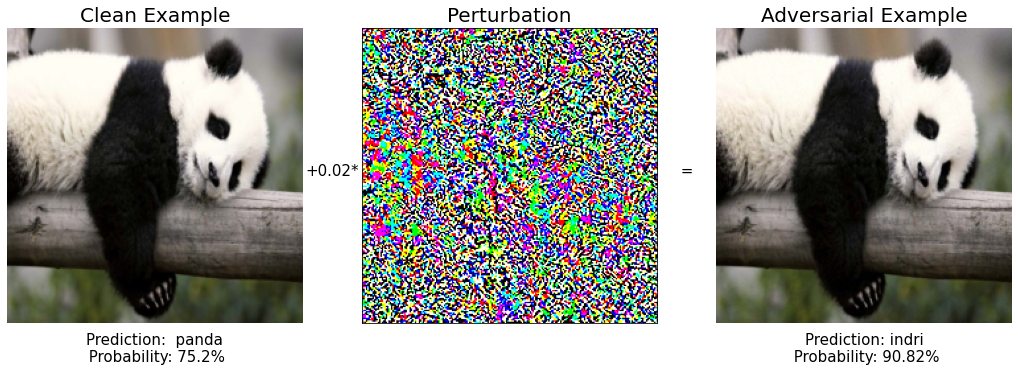

In [18]:
visualize(image_tensor, x_adversarial, x_grad, eps, x_pred.split(",")[1], x_adv_pred.split(",")[0], x_pred_prob, adv_pred_prob)